## 1. Setup and Configuration

In [ ]:
# ### 1.1 Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy import stats
from scipy.sparse import issparse # For checking sparse matrix type
import re
import json
import scanpy as sc
import anndata
import scipy
from collections import defaultdict, Counter
import os
import time
import datetime
import torch
import pickle as pk
from matplotlib_venn import venn2,venn3
import warnings
import requests
from io import BytesIO
from pathlib import Path # For better path handling
from Bio import Entrez # External Call
from sklearn.preprocessing import StandardScaler

import utils
from utils import * # Custom utility functions

# reimport utils
import importlib
importlib.reload(utils)
from utils import * # Custom utility functions

/msc/home/q56ppene/miniconda3/envs/cellwhisperer/lib/python3.10/site-packages/scanpy/_metadata.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# CellWhisperer specific imports
from cellwhisperer.utils.model_io import load_cellwhisperer_model
from cellwhisperer.utils.inference import score_transcriptomes_vs_texts

/msc/home/q56ppene/miniconda3/envs/cellwhisperer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/msc/home/q56ppene/miniconda3/envs/cellwhisperer/lib/python3.10/site-packages/wandb/analytics/sentry.py:90: SentryHubDeprecationWarning: `sentry_sdk.Hub` is deprecated and will be removed in a future major release. Please consult our 1.x to 2.x migration guide for details on how to migrate `Hub` usage to the new API: https://docs.sentry.io/platforms/python/migration/1.x-to-2.x
  self.hub = sentry_sdk.Hub(client)


### 1.2 Configuration & Constants

In [ ]:
RERUN_M1_MARKER_FINDING = True
RERUN_LITERATURE_SEARCH = False
RERUN_CW_PREDICTIONS = False

In [ ]:
ADATA_INPUT_PATH = Path(snakemake.input.processed_adata )
MARKER_GENE_XLS_PATH = snakemake.input.marker_genes
CW_CHECKPOINT_PATH = Path(snakemake.input.model)  
MPL_STYLE = Path(snakemake.input.mpl_style)
OUTPUT_DIR = Path(snakemake.output.result_dir)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# Parameters
SEED = 25
BACKGROUND_GENE_SET_SIZE = 10000 # Used for Fisher's exact test background
CELL_QUANTILE_THRESHOLD = 0.97 # For selecting top scoring cells
MARKER_LOGFC_THRESHOLD = 1.5
MARKER_FDR_THRESHOLD = 0.05 # For selecting marker genes & Fisher's test significance
PUBMED_EMAIL = None # set your email here - not needed when RERUN_LITERATURE_SEARCH = False
PUBMED_API_KEY = None # Replace with your actual API key  - not needed when RERUN_LITERATURE_SEARCH = False
PUBMED_RATE_LIMIT_DELAY = 0.12 #0.5 # Seconds between Entrez queries to avoid blocking (10/sec allowed with API key)

In [6]:
ORGAN_GERM_LAYER_ASSOC_DICT = {
    'blood': 'mesoderm',
    'cerebrum': 'ectoderm',
    'heart': 'mesoderm',
    'intestine': 'endoderm',
    'kidney': 'mesoderm',
    'large intestine': 'endoderm',
    'liver': 'endoderm',
    'lung': 'endoderm',
    'muscle': 'mesoderm',
    'pancreas': 'endoderm',
    'skin': 'ectoderm',
    'small intestine': 'endoderm',
    'spleen': 'mesoderm',
    'stomach': 'endoderm',
    'vasculature': 'mesoderm'
}

In [7]:
ORGANS_BBI = [
    "Cerebrum", "Heart", "Intestine", "Kidney", "Liver", "Lung",
    "Muscle", "Pancreas", "Spleen", "Stomach"
] 
ORGANS_BBI_LOWER = [x.lower() for x in ORGANS_BBI]
ALL_ORGANS = ORGANS_BBI_LOWER

In [8]:
# Lists of terms for CellWhisperer scoring (combine all needed)
ALL_CW_TERMS = sorted(list(set(
    ALL_ORGANS
    # Add Carnegie terms/descriptions later
)))

In [9]:
# Enrichment Libraries
ENRICHMENT_LIBRARIES = [
    'GO_Biological_Process_2023',
    'GO_Molecular_Function_2023',
    'GO_Cellular_Component_2023',
    'KEGG_2021_Human'
]

### 1.3 Global Settings & Environment

In [10]:
# Set global seeds
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [11]:
# Set plotting style defaults
matplotlib.style.use(MPL_STYLE)
plt.style.use("default")
sns.set_style("whitegrid")
matplotlib.rcParams['pdf.fonttype'] = 42 # Ensure editable text in PDFs
matplotlib.rcParams['ps.fonttype'] = 42

In [12]:
warnings.filterwarnings("ignore", category=UserWarning, message=".*Observation names are not unique.*")
warnings.filterwarnings("ignore", category=FutureWarning)

## 3. Data Loading and Initial Processing

In [13]:
print("\n--- Loading Data ---")
try:
    adata = anndata.read_h5ad(ADATA_INPUT_PATH) #, backed="r"
    print(f"Loaded AnnData object: {adata.shape}")
except FileNotFoundError:
    print(f"Error: AnnData file not found at {ADATA_INPUT_PATH}")
    raise SystemExit("Input data file missing.")


--- Loading Data ---
Loaded AnnData object: (95092, 10000)


In [14]:
adata

AnnData object with n_obs × n_vars = 95092 × 10000
    obs: 'anno_og', 'age', 'batch', 'instrument', 'institution', 'protocol', 'AvgReadLen', 'country', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_type', 'tissue_ontology_term_id', 'Clusters', '_X', '_Y', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'anno_og_time', '_scvi_batch', '_scvi_labels'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'anno_og_colors', 'batch_colors', 'scvi', 'umap'
    obsm: 'X_umap', 'scvi'
    la

In [ ]:
adata.var = adata.var.set_index('gene_name')

NameError: name 'adata' is not defined

In [ ]:
# --- Load Marker Genes ---
marker_genes_df = pd.read_excel(MARKER_GENE_XLS_PATH, sheet_name='Table_S3', skiprows=1)
expanded_marker_genes_df = pd.read_excel(MARKER_GENE_XLS_PATH, sheet_name='Table S2', skiprows=1)
print("Loaded BBI marker gene tables.")


Loaded BBI marker gene tables.


## 4. CellWhisperer Scoring (Local Model)

In [18]:
print("\n--- Running CellWhisperer Scoring (Local Model) ---")


--- Running CellWhisperer Scoring (Local Model) ---


In [19]:
carnegie_grouped_descriptions = {
    'Zygote_Carnegie_Derived': "The embryonic stage begins with a fertilized oocyte containing pronuclei. It progresses with cell division, reducing cytoplasmic volume and forming inner and outer cell masses.",
    'Blastula_Carnegie_Derived': "The blastula stage begins with the loss of the zona pellucida, forming a free blastocyst. It progresses as the blastocyst attaches and implants into the uterine lining.",
    'Gastrula_Carnegie_Derived': "During the gastrula stage, the extraembryonic mesoderm and primitive streak form. In the neurula stage, gastrulation continues with the appearance of the notochordal process, primitive pit, and notochordal canal.",
    'Organogenesis_Carnegie_Derived': "During organogenesis, somites progressively form, neural folds fuse, and the rostral and caudal neuropores close. As development continues, limb buds, sensory structures, and facial features emerge, followed by ossification, trunk straightening, and the rounding of the head, body, and limbs."
}
ALL_CW_TERMS.extend([d.lower() for d in carnegie_grouped_descriptions.values()])
CARNEGIE_GROUPED_TERMS= list(carnegie_grouped_descriptions.values())

In [20]:
# Ensure unique terms
ALL_CW_TERMS = sorted(list(set(ALL_CW_TERMS)))
print(f"Total unique terms/descriptions for CellWhisperer scoring: {len(ALL_CW_TERMS)}")

Total unique terms/descriptions for CellWhisperer scoring: 14


In [ ]:
if RERUN_CW_PREDICTIONS:
    # --- Load Local Model ---
    try:
        print(f"Loading CellWhisperer model from: {CW_CHECKPOINT_PATH}")
        pl_model_cellwhisperer, text_processor_cellwhisperer, transcriptome_processor_cellwhisperer = load_cellwhisperer_model(
            model_path=str(CW_CHECKPOINT_PATH), 
            eval=True
        )
        # Determine device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        pl_model_cellwhisperer.to(device)
        print(f"Model loaded successfully onto {device}.")

        # --- Score Transcriptomes vs All Terms ---
        # May require significant memory depending on n_cells and n_terms.
        if "transcriptome_embeds" in adata.obsm.keys():
            transcriptome_embeds_tensor = torch.tensor(
                adata.obsm["transcriptome_embeds"].A if issparse(adata.obsm["transcriptome_embeds"]) else adata.obsm["transcriptome_embeds"],
                device=device
            )
            transcriptome_input=transcriptome_embeds_tensor
        else:
            print("Using raw gene expression data for scoring - may be slow")
            transcriptome_input=adata

        print(f"Scoring {adata.shape[0]} cells against {len(ALL_CW_TERMS)} terms...")
        scores_tensor, _ = score_transcriptomes_vs_texts(
            model=pl_model_cellwhisperer.model,
            logit_scale=pl_model_cellwhisperer.model.discriminator.temperature.exp(),
            transcriptome_input=transcriptome_input,
            text_list_or_text_embeds=ALL_CW_TERMS,
            average_mode=None, # Get scores per cell
            grouping_keys=None,
            transcriptome_processor=transcriptome_processor_cellwhisperer, # Pass processor if needed by model version
            batch_size=64, # Adjust batch size based on GPU memory
            score_norm_method=None, # Or 'tensor', 'global_norm' etc. if needed
        )
        scores_np = scores_tensor.T.cpu().numpy() # n_cells * n_text
        print("Scoring complete.")

        # Add scores to adata.obs
        for i, term in enumerate(ALL_CW_TERMS):
            col_name = f"cw_score_{term.replace(' ', '_').replace('.', '').replace(',', '').lower()}"
            adata.obs[col_name] = scores_np[:, i]

        print(f"Added {len(ALL_CW_TERMS)} CellWhisperer scores to adata.obs")

    except FileNotFoundError:
        print(f"Error: CellWhisperer model checkpoint not found at {CW_CHECKPOINT_PATH}")
        raise SystemExit("CellWhisperer model missing.")
    except Exception as e:
        print(f"An error occurred during CellWhisperer scoring: {e}")
        raise SystemExit("CellWhisperer scoring failed.")
else:
    for term in ALL_CW_TERMS:
        assert f"cw_score_{term.replace(' ', '_').replace('.', '').replace(',', '').lower()}" in adata.obs.columns, f"Missing CellWhisperer score for term: {term}"

## 5. Marker Gene Scoring (BBI Reference)

In [22]:
print("\n--- Calculating BBI Reference Marker Gene Scores ---")

# --- Prepare BBI Marker Gene Sets ---
available_genes = set(adata.var_names)
print(f"{len(available_genes)} genes available in AnnData for scoring.")

organ_marker_genes_dict = defaultdict(set)
organ_extended_marker_genes_dict = defaultdict(set)

for organ_bbi in ORGANS_BBI_LOWER:
    # Regular markers
    markers_for_organ = set()
    # Find rows matching the organ (case-insensitive)
    organ_rows = marker_genes_df[marker_genes_df['Organ'].str.lower() == organ_bbi]
    for _, row in organ_rows.iterrows():
        gene_string = row['Gene markers supporting annotation']
        if pd.notna(gene_string):
            # Split, strip whitespace, and filter by available genes
            genes = {g.strip() for g in gene_string.split(',') if g.strip() in available_genes}
            markers_for_organ.update(genes)
    organ_marker_genes_dict[organ_bbi] = markers_for_organ

    # Extended markers (start with regular markers)
    extended_markers_for_organ = set(markers_for_organ) # Start with the base set
    # Filter expanded table for the organ (handle 'Brain' mapping to 'cerebrum')
    expanded_marker_genes_df['qval'] = pd.to_numeric(expanded_marker_genes_df['qval'], errors='coerce')
    relevant_expanded_rows = expanded_marker_genes_df[
        (expanded_marker_genes_df['qval'] < 0.05) &
        (
            (expanded_marker_genes_df['max_organ'].str.lower() == organ_bbi) |
            ((organ_bbi == 'cerebrum') & (expanded_marker_genes_df['max_organ'] == 'Brain'))
        )
    ]
    # Add genes from relevant rows, stripping quotes and checking availability
    for _, row in relevant_expanded_rows.iterrows():
        gene = str(row['gene_short_name']).replace("'", "").strip()
        if gene in available_genes:
            extended_markers_for_organ.add(gene)
    organ_extended_marker_genes_dict[organ_bbi] = extended_markers_for_organ

# --- Calculate Scores using scanpy.tl.score_genes ---
for organ in ORGANS_BBI_LOWER:
    for name, gene_dict in [("regular", organ_marker_genes_dict), ("extended", organ_extended_marker_genes_dict)]:
        gene_list = list(gene_dict[organ])
        score_name = f"score_{organ}_{name}"
        if gene_list: # Only score if gene list is not empty
            sc.tl.score_genes(adata, gene_list=gene_list, score_name=score_name, use_raw=False)
            # Check if score column was actually added before printing
            if score_name in adata.obs.columns:
                    print(f"Calculated {score_name} using {len(gene_list)} genes.")
            else:
                    warnings.warn(f"Failed to calculate {score_name}. Check gene list and data.")
        else:
            print(f"Skipping {score_name}: No marker genes found/available for {organ}.")
            # Add an empty column to avoid KeyErrors later if expected
            adata.obs[score_name] = 0.0


--- Calculating BBI Reference Marker Gene Scores ---
10000 genes available in AnnData for scoring.
Calculated score_cerebrum_regular using 15 genes.
Calculated score_cerebrum_extended using 399 genes.
Calculated score_heart_regular using 51 genes.
Calculated score_heart_extended using 499 genes.
Calculated score_intestine_regular using 39 genes.
Calculated score_intestine_extended using 545 genes.
Calculated score_kidney_regular using 39 genes.
Calculated score_kidney_extended using 319 genes.
Calculated score_liver_regular using 40 genes.
Calculated score_liver_extended using 556 genes.
Calculated score_lung_regular using 47 genes.
Calculated score_lung_extended using 329 genes.
Calculated score_muscle_regular using 36 genes.
Calculated score_muscle_extended using 420 genes.
Calculated score_pancreas_regular using 44 genes.
Calculated score_pancreas_extended using 293 genes.
Calculated score_spleen_regular using 33 genes.
Calculated score_spleen_extended using 524 genes.
Calculated s

In [23]:
# Save reference markers used (for reproducibility)
if organ_extended_marker_genes_dict:
    pk_path_ref = OUTPUT_DIR / 'reference_BBI_extended_marker_genes.pickle'
    with open(pk_path_ref, 'wb') as handle:
        pk.dump(organ_extended_marker_genes_dict, handle, protocol=pk.HIGHEST_PROTOCOL)
    print(f"Saved reference (BBI Extended) marker genes used for validation to: {pk_path_ref}")

Saved reference (BBI Extended) marker genes used for validation to: /msc/home/q56ppene/cellwhisperer/cellwhisperer/results/plots/development_analysis/output/reference_BBI_extended_marker_genes.pickle


## 6. Developmental Stage Analysis


--- Analyzing Developmental Stage Scores ---
Saved heatmap to: /msc/home/q56ppene/cellwhisperer/cellwhisperer/results/plots/development_analysis/output/dev_terms_carnegie_grouped_heatmap_absolute.pdf


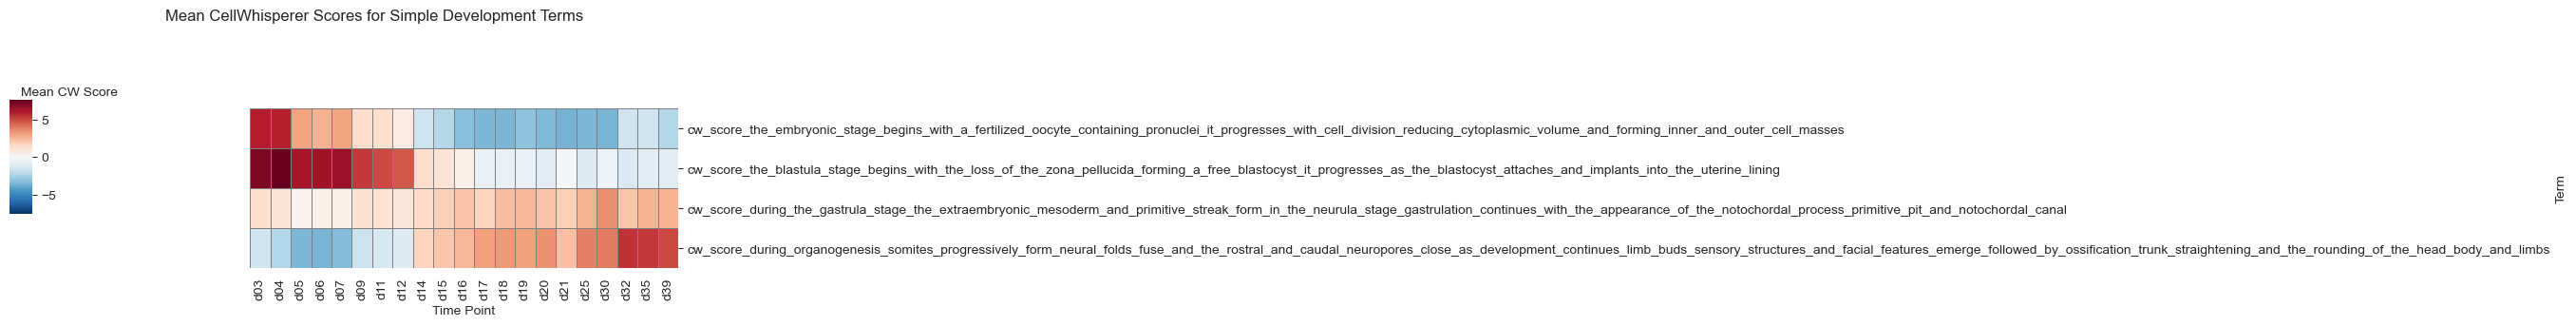

In [ ]:
print("\n--- Analyzing Developmental Stage Scores ---")

# --- Grouped Carnegie terms
terms_cols_carnegie_grouped = [f"cw_score_{term.replace(' ', '_').replace('.', '').replace(',', '').lower()}" for term in CARNEGIE_GROUPED_TERMS if f"cw_score_{term.replace(' ', '_').replace('.', '').replace(',', '').lower()}" in adata.obs.columns]
if terms_cols_carnegie_grouped:
    means_carnegie_grouped = adata.obs.groupby("Timepoint (day)")[terms_cols_carnegie_grouped].mean()

    plot_mean_score_heatmap(means_carnegie_grouped, "Mean CellWhisperer Scores for Simple Development Terms",
                            "dev_terms_carnegie_grouped_heatmap_absolute.pdf", OUTPUT_DIR,
                            cbar_title="Mean CW Score")

## 7. Organ Temporal Emergence Analysis

In [25]:
print("\n--- Analyzing Temporal Emergence of Organs ---")


--- Analyzing Temporal Emergence of Organs ---


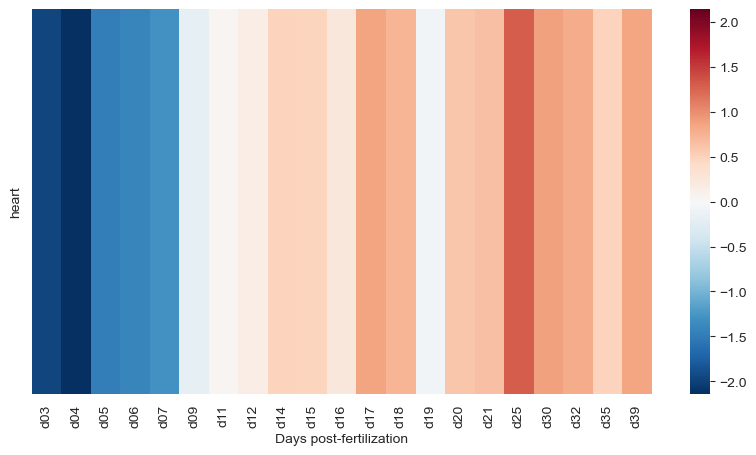

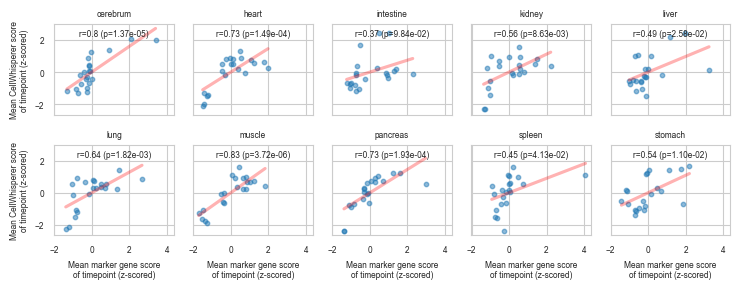

In [ ]:
# --- Calculate Timepoint Statistics ---
temporal_stats = defaultdict(lambda: defaultdict(dict))  # organ -> metric -> timepoint -> value

all_timepoints = sorted(
    adata.obs['Timepoint (day)'].cat.categories
    if pd.api.types.is_categorical_dtype(adata.obs['Timepoint (day)'])
    else sorted(adata.obs['Timepoint (day)'].unique())
)

for organ_label in ALL_ORGANS:
    organ_cw_col = f"cw_score_{organ_label.replace(' ','_')}"
    organ_gene_score_col = f"score_{organ_label.replace(' ','_')}_extended"

    for timepoint in all_timepoints:
        adata_timepoint = adata[adata.obs["Timepoint (day)"] == timepoint]

        cw_scores_tp = adata_timepoint.obs[organ_cw_col]
        temporal_stats[organ_label]["mean_cw_score"][timepoint] = cw_scores_tp.mean()

        if organ_gene_score_col in adata.obs.columns:
            gene_scores_tp = adata_timepoint.obs[organ_gene_score_col]
            temporal_stats[organ_label]["mean_gene_score"][timepoint] = gene_scores_tp.mean()

# Create temporal dataframes
metrics_to_plot = ["mean_cw_score", "mean_gene_score"]
temporal_dfs = {}
for metric in metrics_to_plot:
    df_data = {organ: stats[metric] for organ, stats in temporal_stats.items() if metric in stats}
    if df_data:
        temporal_dfs[metric] = pd.DataFrame(df_data).reindex(all_timepoints)

# --- Heart Heatmap ---
if "mean_cw_score" in temporal_dfs:
    # Plot heart temporal scores
    heart_scores = temporal_dfs["mean_cw_score"][["heart"]].dropna(axis=1, how='all')
    
    if not heart_scores.empty:
        # Z-score normalization
        scaler = StandardScaler()
        heart_scores_z = pd.DataFrame(scaler.fit_transform(heart_scores),
                                    index=heart_scores.index, columns=heart_scores.columns)
        
        # Set symmetric color scale
        vmin = heart_scores_z.min().min()
        vmax = heart_scores_z.max().max()
        absmax = max(abs(vmin), abs(vmax))
        vmin = -absmax
        vmax = absmax

        # Create heatmap
        sns.heatmap(heart_scores_z.T, cmap="RdBu_r",
                    vmin=vmin, vmax=vmax, yticklabels=True,
                    xticklabels=True, linewidths=0)

        plt.gca().grid(False)
        plt.gca().patch.set_facecolor('white')
        plt.xlabel("Days post-fertilization")
        plt.gcf().set_size_inches(10, 5)
        plt.savefig(OUTPUT_DIR / "temporal_comparison_heart.pdf")
        plt.show()

# --- Gene vs CW Score Scatter Plot ---
if "mean_cw_score" in temporal_dfs and "mean_gene_score" in temporal_dfs:
    cw_scores_df = temporal_dfs["mean_cw_score"][ORGANS_BBI_LOWER].dropna(axis=1, how='all')
    gene_scores_df = temporal_dfs["mean_gene_score"][ORGANS_BBI_LOWER].dropna(axis=1, how='all')

    common_organs = sorted(list(set(cw_scores_df.columns) & set(gene_scores_df.columns)))
    cw_scores_df = cw_scores_df[common_organs].dropna(how='all')
    gene_scores_df = gene_scores_df[common_organs].dropna(how='all')
    common_time = sorted(list(set(cw_scores_df.index) & set(gene_scores_df.index)))
    cw_scores_df = cw_scores_df.loc[common_time]
    gene_scores_df = gene_scores_df.loc[common_time]

    if not cw_scores_df.empty and not gene_scores_df.empty:
        # Z-score normalize both datasets
        scaler = StandardScaler()
        cw_scores_z = pd.DataFrame(scaler.fit_transform(cw_scores_df),
                                    index=cw_scores_df.index, columns=cw_scores_df.columns)
        gene_scores_z = pd.DataFrame(scaler.fit_transform(gene_scores_df),
                                        index=gene_scores_df.index, columns=gene_scores_df.columns)

        # Calculate pearson correlations for scatter plot
        pearson_results = []
        for i in range(gene_scores_df.shape[1]):
            r, pval = stats.pearsonr(x=gene_scores_df.iloc[:, i], y=cw_scores_z.iloc[:, i])
            formatted_pval = f"(p={pval:.2e})"
            pearson_results.append((r, formatted_pval))

        # Prepare data for scatter plot
        common_df = cw_scores_z.melt(var_name="organ", value_name="cw_score")
        common_df["z_score"] = gene_scores_z.melt(var_name="organ", value_name="z_score")["z_score"]

        # Create subplots - two rows
        n_organs = len(common_organs)
        n_cols = (n_organs + 1) // 2  # Calculate columns needed for 2 rows
        fig, axes = plt.subplots(2, n_cols, figsize=(n_cols*1.5 , 3), sharex=True, sharey=True)

        axes_flat = axes.flatten()

        for i, organ in enumerate(common_organs):
            organ_data = common_df[common_df["organ"] == organ]
            
            sns.regplot(x="z_score", y="cw_score", data=organ_data, ax=axes_flat[i],
                        scatter_kws={'s': 10, 'alpha': 0.5}, line_kws={'color': 'red',"alpha":0.3},
                        ci=None)
            
            # Annotate the r and p-value on each subplot
            pearsonres = pearson_results[i]
            axes_flat[i].annotate(f"r={round(pearsonres[0], 2)} {pearsonres[1]}",
                                xy=(0.5, 0.9), xycoords="axes fraction",
                                ha="center", va="center", fontsize=6)
            
            axes_flat[i].set_title(organ, fontsize=6)
            
            # Only show x labels for bottom row
            if i >= n_organs - n_cols:  # Bottom row
                axes_flat[i].set_xlabel("Mean marker gene score\nof timepoint (z-scored)", fontsize=6)
            else:
                axes_flat[i].set_xlabel("")
            
            # Only show y labels for leftmost column
            if i % n_cols == 0:  # First column of each row
                axes_flat[i].set_ylabel("Mean CellWhisperer score\nof timepoint (z-scored)", fontsize=6)
            else:
                axes_flat[i].set_ylabel("")
            
            # Set tick label font size
            axes_flat[i].tick_params(axis='both', which='major', labelsize=6)

        # Hide any unused subplots
        for j in range(n_organs, len(axes_flat)):
            axes_flat[j].set_visible(False)

        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / "temporal_comparison_gene_vs_cw_scatter.pdf")
        plt.show()
        plt.close()

else:
    print("Skipping plots: Missing required temporal data.")

## 8. CW-Organ Marker Gene Identification & Validation

In [27]:
#  Differential Expression on Top Scoring Cells ---

pk_path_genes_m1 = OUTPUT_DIR / 'CW_organs_marker_genes_method1.pickle'
pk_path_dfs_m1 = OUTPUT_DIR / 'CW_organs_marker_genes_dfs_method1.pickle'
pk_path_cells_m1 = OUTPUT_DIR / 'CW_organs_marker_genes_cells_method1.pickle'

if RERUN_M1_MARKER_FINDING or (not pk_path_genes_m1.exists()) or (not pk_path_dfs_m1.exists()) or (not pk_path_cells_m1.exists()):
    print("\n--- Identifying CellWhisperer-based Organ Marker Genes ---")
    print("\n---  DE on Top Scoring Cells ---")
    cw_markers_m1 = {}
    cw_dfs_m1 = {}
    cw_cells_m1 = {}
    # Check if required columns exist
    required_obs_cols = [f"cw_score_{org}" for org in ORGANS_BBI_LOWER]
    if not all(col in adata.obs.columns for col in required_obs_cols):
        warnings.warn("Skipping CW Marker Gene: Missing required CellWhisperer score columns.")
    else:
        for organ in ORGANS_BBI_LOWER:
            cw_col = f"cw_score_{organ}"
            score_threshold = adata.obs[cw_col].quantile(CELL_QUANTILE_THRESHOLD)
            top_scoring_mask = adata.obs[cw_col] > score_threshold

            if top_scoring_mask.sum() < 10: # Need sufficient cells in group for DE
                warnings.warn(f"Skipping DE for {organ} : Less than 10 cells found above {CELL_QUANTILE_THRESHOLD:.0%} quantile threshold.")
                continue

            cw_cells_m1[organ] = adata.obs.index[top_scoring_mask].tolist()

            # Define groups for rank_genes_groups
            group_label = f"{organ}_top_vs_rest"
            adata.obs[group_label] = np.where(top_scoring_mask, f"{organ}_top", f"{organ}_rest")
            adata.obs[group_label] = adata.obs[group_label].astype("category")

            print(f"Running DE for {organ}: {top_scoring_mask.sum()} top cells vs rest...")

            sc.tl.rank_genes_groups(adata, group_label, method='wilcoxon',
                                    groups=[f"{organ}_top"], reference=f"{organ}_rest",
                                    n_genes=adata.shape[1], # Get stats for all genes
                                    )

            de_results_df = sc.get.rank_genes_groups_df(adata, group=f"{organ}_top")

            cw_dfs_m1[organ] = de_results_df.copy() # Store for later use

            # Filter significant up-regulated genes
            significant_markers = de_results_df[
                (de_results_df['pvals_adj'] < MARKER_FDR_THRESHOLD) &
                (de_results_df['logfoldchanges'] > MARKER_LOGFC_THRESHOLD)
            ]['names'].tolist()

            cw_markers_m1[organ] = significant_markers
            print(f"Found {len(significant_markers)} marker genes for {organ} .")


        # Save markers
        if cw_markers_m1:
            with open(pk_path_genes_m1, 'wb') as handle:
                pk.dump(cw_markers_m1, handle, protocol=pk.HIGHEST_PROTOCOL)
            print(f"Saved marker genes to: {pk_path_genes_m1}")

            with open(pk_path_dfs_m1, 'wb') as handle:
                pk.dump(cw_dfs_m1, handle, protocol=pk.HIGHEST_PROTOCOL)
            print(f"Saved DE results to: {pk_path_dfs_m1}")

            with open(pk_path_cells_m1, 'wb') as handle:
                pk.dump(cw_cells_m1, handle, protocol=pk.HIGHEST_PROTOCOL)
            print(f"Saved top cells to: {pk_path_cells_m1}")

        
else:
    print(f"Loading data from pickled files")
    with open(pk_path_genes_m1, 'rb') as handle:
        cw_markers_m1 = pk.load(handle)
        lens={k: len(v) for k, v in cw_markers_m1.items()}
        print(f"Numbers of marker genes: {lens}")
    with open(pk_path_dfs_m1, 'rb') as handle:
        cw_dfs_m1 = pk.load(handle)
    with open(pk_path_cells_m1, 'rb') as handle:
        cw_cells_m1 = pk.load(handle)
    


--- Identifying CellWhisperer-based Organ Marker Genes ---

---  DE on Top Scoring Cells ---
Running DE for cerebrum: 2853 top cells vs rest...
running


ran
Found 670 marker genes for cerebrum .
Running DE for heart: 2853 top cells vs rest...
running
ran
Found 321 marker genes for heart .
Running DE for intestine: 2853 top cells vs rest...
running
ran
Found 1252 marker genes for intestine .
Running DE for kidney: 2853 top cells vs rest...
running
ran
Found 492 marker genes for kidney .
Running DE for liver: 2853 top cells vs rest...
running


KeyboardInterrupt: 

## 9. Literature Analysis (PubMed)

This section relies heavily on external calls to NCBI Entrez.
It's slow, requires an internet connection, and is subject to rate limits.
Consider using pre-compiled gene-literature databases (RERUN_LITERATURE_SEARCH=False)

In [ ]:
print("\n--- Performing Literature Analysis (PubMed Search) ---")
Entrez.email = PUBMED_EMAIL
Entrez.api_key = PUBMED_API_KEY


if PUBMED_EMAIL == "your_email@example.com":
    warnings.warn("PubMed email not set. Using default, which is discouraged.")


--- Performing Literature Analysis (PubMed Search) ---


In [ ]:
if RERUN_LITERATURE_SEARCH or ("literature_search_results" not in adata.uns.keys()):
    literature_df = perform_literature_search(adata.var.index.to_list(), ORGANS_BBI_LOWER, csv_path_lens=CSV_PATH_LITERATURE_RESULTS,
                                              PUBMED_RATE_LIMIT_DELAY=PUBMED_RATE_LIMIT_DELAY,)
else:
    print(f"Loading literature search results from: adata.uns['literature_search_results']")
    literature_df = adata.uns['literature_search_results']

Loading literature search results from: /msc/home/q56ppene/cellwhisperer/cellwhisperer/tmp/output/literature_search_results.csv


In [ ]:
for organ in ORGANS_BBI_LOWER:
    literature_df[f"{organ}: log10(Number of papers + 1)"] = literature_df[f"{organ}: Number of PMIDs"].apply(lambda x : np.log10(x+1))

In [ ]:
# Create a single dataframe with per-gene results
for organ, df in cw_dfs_m1.items():
    cw_dfs_m1[organ].columns = [f"{organ}: {x}" if not x=="names" else x for x in cw_dfs_m1[organ].columns ]
    cw_dfs_m1[organ]=cw_dfs_m1[organ].sort_values(by="names")
    cw_dfs_m1[organ]=cw_dfs_m1[organ].set_index("names")
de_df= pd.concat(cw_dfs_m1.values(), axis=1)

genes_df = pd.merge(literature_df,de_df, left_index=True, right_index=True, how='outer')

In [ ]:
genes_df.head()

,cerebrum: Number of PMIDs,heart: Number of PMIDs,intestine: Number of PMIDs,kidney: Number of PMIDs,liver: Number of PMIDs,lung: Number of PMIDs,muscle: Number of PMIDs,pancreas: Number of PMIDs,spleen: Number of PMIDs,stomach: Number of PMIDs,...,pancreas: pvals,pancreas: pvals_adj,spleen: scores,spleen: logfoldchanges,spleen: pvals,spleen: pvals_adj,stomach: scores,stomach: logfoldchanges,stomach: pvals,stomach: pvals_adj
A1BG,0,8,3,6,20,7,3,1,1,1,...,2.543405e-49,3.972208e-49,-9.895169,-0.367252,4.368723e-23,5.741521e-23,7.978491,-0.189093,1.481336e-15,1.613480e-15
A1CF,0,3,9,11,20,5,2,0,0,0,...,0.000000e+00,0.000000e+00,-1.520535,-0.598671,1.283766e-01,1.332952e-01,-16.330811,-0.131807,5.958789e-60,7.189659e-60
A2M,7,35,16,30,87,51,35,12,8,10,...,3.989069e-25,5.383359e-25,59.802902,4.304781,0.000000e+00,0.000000e+00,-14.338776,-1.842025,1.252463e-46,1.475570e-46
A2ML1,1,8,0,4,3,5,0,0,0,0,...,1.053575e-23,1.409088e-23,-20.100981,-1.165097,7.234895e-90,1.393470e-89,37.986595,0.487001,0.000000e+00,0.000000e+00
A4GALT,0,4,2,10,4,0,1,0,3,1,...,6.073896e-05,6.748024e-05,-35.475033,-2.250799,1.193001e-275,5.184708e-275,45.783333,1.299402,0.000000e+00,0.000000e+00


In [ ]:
genes_df.shape

(10000, 60)


--- Literature Analysis: Gene Expression vs Literature Coverage ---


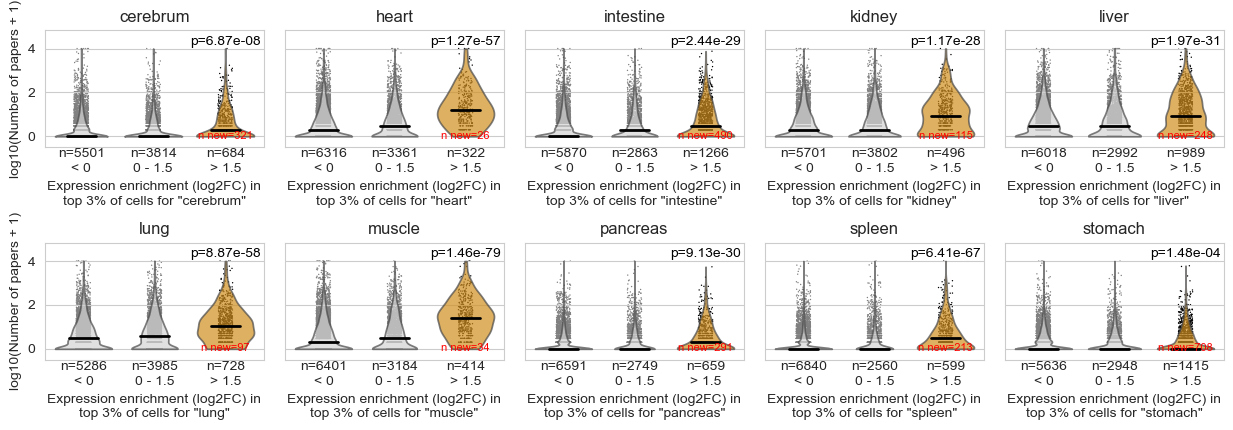

In [ ]:
print("\n--- Literature Analysis: Gene Expression vs Literature Coverage ---")

# Calculate subplot layout
n_organs = len(ORGANS_BBI_LOWER)
n_cols = (n_organs + 1) // 2
n_rows = 2

# Create figure for literature analysis violin plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5*n_cols, 2.2*n_rows), sharey=True)
axes = axes.flatten()

sns.set_style("ticks")

for i, organ in enumerate(ORGANS_BBI_LOWER):
    ax = axes[i]
    plt.sca(ax)
    
    # Define bins for log fold changes
    logfc_col = f"{organ}: logfoldchanges"
    paper_col = f"{organ}: log10(Number of papers + 1)"
    
    # Create bins for expression enrichment
    bins = [genes_df[logfc_col].min(), 0, MARKER_LOGFC_THRESHOLD, genes_df[logfc_col].max()]
    genes_df["bin"] = pd.cut(genes_df[logfc_col], bins=bins)
    genes_df["above_cutoff"] = genes_df[logfc_col] >= MARKER_LOGFC_THRESHOLD
    
    # Categorize genes
    def categorize_gene(row):
        if row[logfc_col] >= MARKER_LOGFC_THRESHOLD:
            return "above cutoff and new" if row[paper_col] == 0 else "above cutoff and known"
        return "below cutoff"
    
    genes_df["category"] = genes_df.apply(categorize_gene, axis=1)
    
    # Set rasterization for better performance with many points
    plt.gca().set_rasterization_zorder(0.001)
    
    # Create strip plot first (background layer)
    sns.stripplot(data=genes_df, x="bin", y=paper_col, 
                  hue="category", size=1, jitter=True, dodge=False,
                  palette={"above cutoff and new":"red", "above cutoff and known":"black", "below cutoff":"grey"},
                  ax=ax, zorder=0)
    
    # Create violin plot overlay
    sns.violinplot(data=genes_df, x="bin", y=paper_col, inner=None,
                   hue="above_cutoff", palette={True:"#ee9703", False:"lightgrey"}, 
                   alpha=0.7, cut=0, dodge=False, ax=ax, zorder=1)
    
    # Set labels and formatting
    ax.set_xticklabels(["< 0", f"0 - {MARKER_LOGFC_THRESHOLD}", f"> {MARKER_LOGFC_THRESHOLD}"])
    ax.set_xlabel(f'Expression enrichment (log2FC) in\ntop {int((1-CELL_QUANTILE_THRESHOLD)*100)}% of cells for "{organ}"')
    ax.set_ylabel(paper_col.replace(f"{organ}: ", ""))
    ax.set_title(organ)
    
    # Add median lines and sample counts
    for j, bin_cat in enumerate(genes_df["bin"].cat.categories):
        bin_data = genes_df[genes_df["bin"] == bin_cat]
        median = bin_data[paper_col].median()
        ax.plot([j-0.2, j+0.2], [median, median], color="black", linewidth=2)
        
        # Add sample size below x-axis
        n_total = len(bin_data)
        ax.text(j, -1.08, f"n={n_total}", fontsize=10, ha='center', va='bottom')
        
        # Add count of new genes 
        n_new = len(bin_data[bin_data[paper_col] == 0])
        if len(bin_data[bin_data["above_cutoff"]]) > 0:
            ax.text(j, -0.2, f"n new={n_new}", fontsize=8, ha='center', va='bottom', color="red")
    
    # Statistical test between first and last bin
    first_bin = genes_df["bin"].cat.categories[0]
    last_bin = genes_df["bin"].cat.categories[-1]
    
    ref_data = genes_df[genes_df["bin"] == first_bin][paper_col].values
    test_data = genes_df[genes_df["bin"] == last_bin][paper_col].values
    
    if len(ref_data) > 0 and len(test_data) > 0:
        u_stat, pval = stats.mannwhitneyu(ref_data, test_data, alternative="two-sided")
        ax.text(j, genes_df[paper_col].max()*1.01, f"p={pval:.2e}", 
                fontsize=10, ha='center', va='bottom', color="black")
    
    # Format tick parameters
    ax.tick_params(axis='x', pad=8)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    
    # Clean up plot
    ax.legend([], [], frameon=False)
    ax.set_ylim(-0.5, ax.get_ylim()[1])
    
    # Add red rectangle highlight (optional - uncomment if needed)
    # rect = patches.Rectangle((1.5, -0.21), 1, 0.3, linewidth=1, edgecolor='red', facecolor="none")
    # ax.add_patch(rect)

# Hide empty subplots
for j in range(n_organs, len(axes)):
    axes[j].set_visible(False)

# Adjust y-limits
plt.figure(fig.number)
ylim_lower, ylim_upper = plt.ylim()
plt.ylim(ylim_lower, ylim_upper * 1.15)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "npapers_vs_logfoldchanges.violinplots.pdf", dpi=700, bbox_inches='tight')
plt.show()
plt.close()

# Clean up temporary columns
genes_df.drop(columns=["bin", "above_cutoff", "category"], inplace=True, errors='ignore')

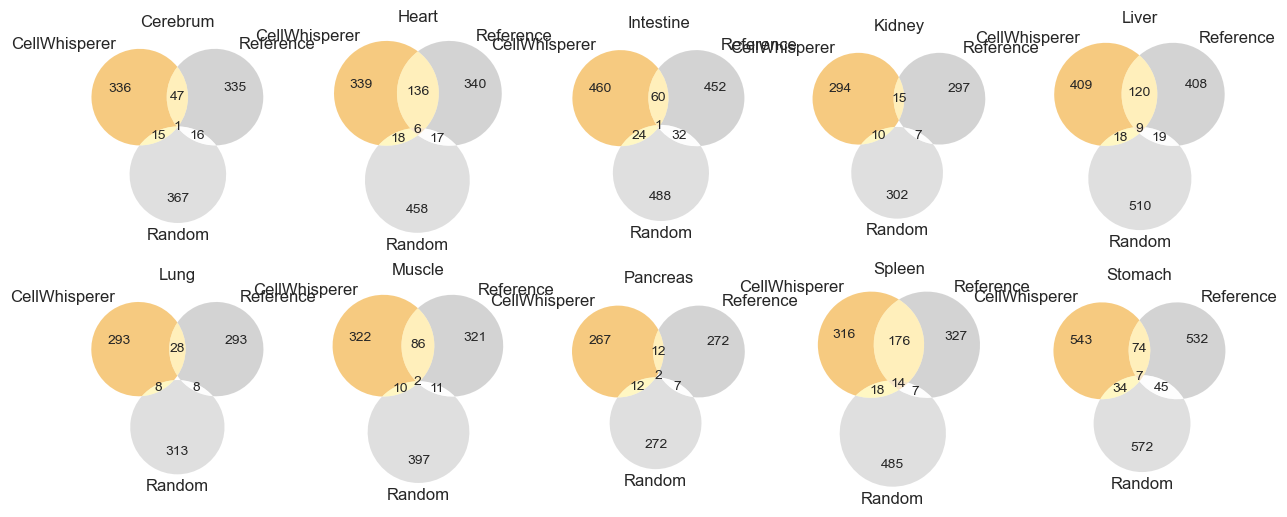

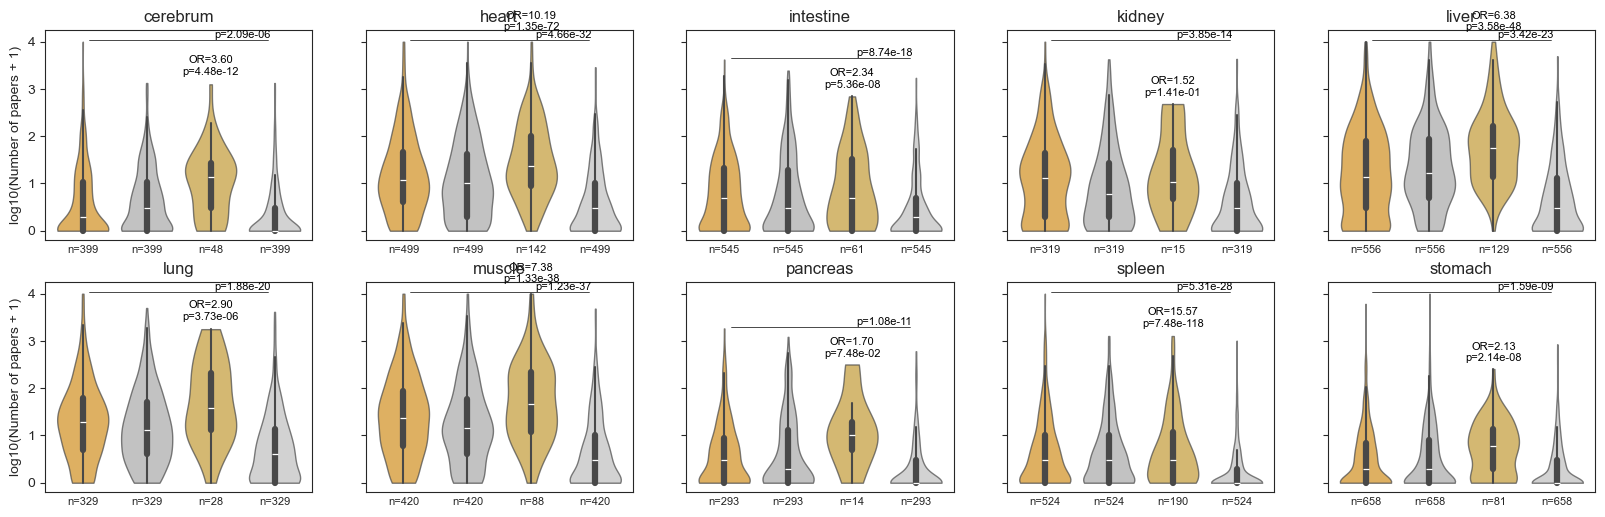

In [ ]:
add_random_genes=True
metric ="logfoldchanges"

fig, axes = plt.subplots(2, len(ORGANS_BBI_LOWER)//2 + len(ORGANS_BBI_LOWER)%2, figsize=((4 if add_random_genes else 3) * (len(ORGANS_BBI_LOWER)//2 + len(ORGANS_BBI_LOWER)%2), 6), sharey=True)
fig2, axes2 = plt.subplots(2, len(ORGANS_BBI_LOWER)//2 + len(ORGANS_BBI_LOWER)%2, figsize=(3 * (len(ORGANS_BBI_LOWER)//2 + len(ORGANS_BBI_LOWER)%2), 6), sharey=True)

axes = axes.flatten()
axes2 = axes2.flatten()

for ax,ax2, organ in zip(axes,axes2, ORGANS_BBI_LOWER):

    metric_df=genes_df[[f"{organ}: {metric}", f"{organ}: log10(Number of papers + 1)"]]

    refgene_df = metric_df.loc[organ_extended_marker_genes_dict[organ]]
    refgene_df["Gene category"]="Reference gene"

    random_genes_df = metric_df.sample(n=len(organ_extended_marker_genes_dict[organ]), random_state=42)
    random_genes_df["Gene category"]="Random gene set"



    passed_cutoff_df=metric_df.sort_values(by=f"{organ}: {metric}", ascending=False).head(refgene_df.shape[0])
    passed_cutoff_df["Gene category"]="CellWhisperer-identified"

    common_genes = set(passed_cutoff_df.index) & set(refgene_df.index)
    common_df = passed_cutoff_df.loc[common_genes].copy()
    common_df["Gene category"]="Common"

    plot_df=pd.concat([passed_cutoff_df,refgene_df, common_df]+([random_genes_df] if add_random_genes else []))
    plt.sca(ax)
    sns.violinplot(data=plot_df, x="Gene category", y=f"{organ}: log10(Number of papers + 1)", order=["CellWhisperer-identified", "Reference gene", "Common"]+ (["Random gene set"] if add_random_genes else []), alpha=0.7, cut=0,dodge=False,
                    hue="Gene category",ax=ax, palette={"CellWhisperer-identified":"#ee9703","Reference gene":"darkgrey", "Common":"goldenrod","Random gene set":"silver"}, linewidth=1)
    # Add N numbers underneath each violin
    for i, category in enumerate(plot_df["Gene category"].unique()):
        if category in ["CellWhisperer-identified", "Reference gene", "Common"] + (["Random gene set"] if add_random_genes else []):
            subset = plot_df[plot_df["Gene category"] == category]
            n_count = len(subset)
            plt.text(i, ax.get_ylim()[0] - 0.1, f"n={n_count}", fontsize=8, ha='center', va='top')

    # remove the x ticks 
    plt.xticks([])
    plt.xlabel("")

    plt.title(f"{organ}")
    plt.ylabel(f"log10(Number of papers + 1)")
    if True:
        # now test passed_cutoff_df vs random
        if add_random_genes and random_genes_df.shape[0] and passed_cutoff_df.shape[0]:
            u_stat, pval = stats.mannwhitneyu(passed_cutoff_df[f"{organ}: log10(Number of papers + 1)"], random_genes_df[f"{organ}: log10(Number of papers + 1)"], alternative="two-sided")
            plt.text(2.5, plot_df[f"{organ}: log10(Number of papers + 1)"].max()*1.01, f"p={pval:.2e}", fontsize=8, ha='center', va='bottom', color="black")
            # add line
            plt.plot([0.1,2.9], [plot_df[f"{organ}: log10(Number of papers + 1)"].max()*1.01]*2, color="black", linewidth=0.5)

    # Calculate an odds ratio, comparing the overlap sizes to expectation 
    if add_random_genes:
        common = len(common_genes)
        only_cw = len(passed_cutoff_df) - common
        only_ref = len(refgene_df) - common
        neither = BACKGROUND_GENE_SET_SIZE - (only_cw + only_ref + common)
        odds_ratio = (common * neither) / (only_cw * only_ref) if only_cw > 0 and only_ref > 0 else np.nan
        fisher_res = stats.fisher_exact([[common, only_cw], [only_ref, neither]])
        # add the odds ratio and p-value to the plot (above the violin for shared genes)
        plt.text(2, common_df[f"{organ}: log10(Number of papers + 1)"].max()*1.05, f"OR={odds_ratio:.2f}\np={fisher_res[1]:.2e}", fontsize=8, ha='center', va='bottom', color="black")

    plt.xticks(rotation=45, ha='right')

    plt.sca(ax2)
    # plot a venn diagram
    if add_random_genes:
        venn3([set(passed_cutoff_df.index), set(refgene_df.index), set(random_genes_df.index)], set_labels=(f'CellWhisperer', 'Reference','Random'),
            ax=ax2, alpha=0.5, set_colors=("#ee9703", "darkgrey","silver"))
    else:
        venn2([set(passed_cutoff_df.index), set(refgene_df.index)], set_labels=(f'CellWhisperer', 'Reference'),
            ax=ax2, alpha=0.5, set_colors=("#ee9703", "darkgrey"))
    plt.title(organ.capitalize())

plt.sca(ax)
plt.savefig(OUTPUT_DIR / f"literature_association_comparison_BBI_vs_{metric}.{'with_random.' if add_random_genes else ''}violinplots.pdf")
plt.show()

plt.sca(ax2)
venn_dir = OUTPUT_DIR / f"venn_diagrams_{metric}_v2"
venn_dir.mkdir(exist_ok=True)
plot_path = venn_dir / f"venn_{metric}{'with_random.' if add_random_genes else ''}.pdf"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.close()


In [ ]:
metric == "logfoldchanges"

for organ in ORGANS_BBI_LOWER:

    metric_df=genes_df[[f"{organ}: {metric}", f"{organ}: log10(Number of papers + 1)"]]

    refgene_df = metric_df.loc[organ_extended_marker_genes_dict[organ]]
    refgene_df["Gene category"]="Reference gene"

    random_genes_df = metric_df.sample(n=len(organ_extended_marker_genes_dict[organ]), random_state=42)
    random_genes_df["Gene category"]="Random gene set"

    cutoff = MARKER_LOGFC_THRESHOLD
    passed_cutoff_df=metric_df[metric_df[f"{organ}: {metric}"]>cutoff]
    passed_cutoff_df["Gene category"]="CellWhisperer-identified"

    enrichment_dir = OUTPUT_DIR / f"enrichment_plots_{metric}"
    enrichment_dir.mkdir(exist_ok=True)
    enr_dict = run_gsea_enrichment(list(passed_cutoff_df.index), ENRICHMENT_LIBRARIES, organism='human')

    # Combine results from different libraries if needed
    valid_dfs = [df for df in enr_dict.values() if not df.empty]
    if valid_dfs:
        combined_enr_df = pd.concat(valid_dfs, ignore_index=True)
        combined_enr_df = combined_enr_df.sort_values("Adjusted P-value")

    gp.dotplot(combined_enr_df,
        column="Adjusted P-value",
        title=f"{organ.capitalize()} - Top Enriched Terms ({metric})",
        ofname=str(enrichment_dir / f"{organ}_enrichment_dotplot_{metric}.larger_{cutoff}.pdf"), # Ensure path is string
        top_term=10, # Show top 10 terms
        figsize=(6, 5),
        marker='o', show_ring=True
    )

In [ ]:
days_expression_df = get_highest_expression_day(adata)
# drop all cols from days_expression_df:
genes_df=genes_df[[x for x in genes_df.columns if not x in days_expression_df.columns]]
genes_df=genes_df.merge(days_expression_df, left_index=True, right_index=True)

suppl_table = genes_df.copy()
suppl_table["CellWhisperer-associated and novel"]=False
suppl_table["CellWhisperer-associated and novel: Organs"]= [[] for _ in range(len(suppl_table))]

keep_cols = ["CellWhisperer-associated and novel","CellWhisperer-associated and novel: Organs"]
for organ in ORGANS_BBI_LOWER:
    selector=(suppl_table[f"{organ}: Number of PMIDs"]==0) & (suppl_table[f"{organ}: logfoldchanges"]>MARKER_LOGFC_THRESHOLD)
    suppl_table.loc[selector, "CellWhisperer-associated and novel"]=True
    # Iterate through selected indices and append to each individual list
    for idx in suppl_table[selector].index:
        suppl_table.at[idx, "CellWhisperer-associated and novel: Organs"].append(organ)
    keep_cols+=[f"{organ}: Number of PMIDs", f"{organ}: logfoldchanges"]
keep_cols += ["CS8_mean_expression_zscore", "CS8_Q97_expression_zscore"]
suppl_table=suppl_table[keep_cols]
# rename all instances of "logfoldchanges" to "expression enrichment (log2FC)"
for col in suppl_table.columns:
    if "logfoldchanges" in col:
        suppl_table.rename(columns={col: col.replace("logfoldchanges", "expression enrichment (log2FC)")}, inplace=True)
# rename "CS8_mean_expression_zscore" to "Mean expression at CS8 (z-score)"
suppl_table.rename(columns={"CS8_mean_expression_zscore": "Mean expression at CS8 (z-score)"}, inplace=True)
# rename "CS8_Q97_expression_zscore" to "Q97 expression at CS8 (z-score)"
suppl_table.rename(columns={"CS8_Q97_expression_zscore": "Q97 expression at CS8 (z-score)"}, inplace=True)
# rename all instances of "Number of PMIDs" to "Number of papers"
for col in suppl_table.columns:
    if "Number of PMIDs" in col:
        suppl_table.rename(columns={col: col.replace("Number of PMIDs", "Number of papers")}, inplace=True)
suppl_table.to_excel(OUTPUT_DIR / "Suppl_table.xlsx")